<a href="https://colab.research.google.com/github/hongkuntian/comp551-applied-machine-learning/blob/master/project3/miniproject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Classification of Image Data

Group 101

* Romanov, Dima  (260831349)
* Shao, Jia Rong (260867038)
* Tian, Hong Kun (260866355)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import os
import glob
import math

SEED = 551

sns.set_palette('muted')

# Set seed for random actions, so that code behaviour is replicable
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
save_path = '/content/drive/My Drive/'

## Preprocessing

In [0]:
n_batch = 64
validation_size = 0.2 # proportion of the training that will be allocated to validation
                      # (since CIFAR10 does not have a provided validation set)

In [0]:
# Set transforms for training (Including a few data augmentation transforms, such as RandomCrop, RandomHorizontalFlip, RandomRotation)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-20,20)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Set transform for test set
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
# Train/validation sets
trainset_no_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Use SubsetRandomSampler to separate into train/validation
set_size = len(trainset)
indices = list(range(set_size))
split = int(np.floor(validation_size * set_size))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

no_aug_train_loader = torch.utils.data.DataLoader(trainset_no_aug, batch_size=n_batch,
                                          sampler=train_sampler, num_workers=4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=n_batch,
                                          sampler=train_sampler, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=n_batch,
                                          sampler=valid_sampler, num_workers=4)

# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=n_batch,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Augmented training images


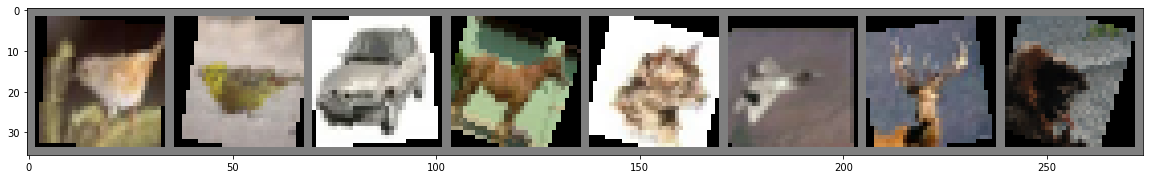

	 bird		   bird		    car		  horse		    cat		  plane		   deer		    cat


In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize=(20,5))
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print('\t'+'\t\t  '.join('%5s' % classes[labels[j]] for j in range(8)))

Non-augmented training images

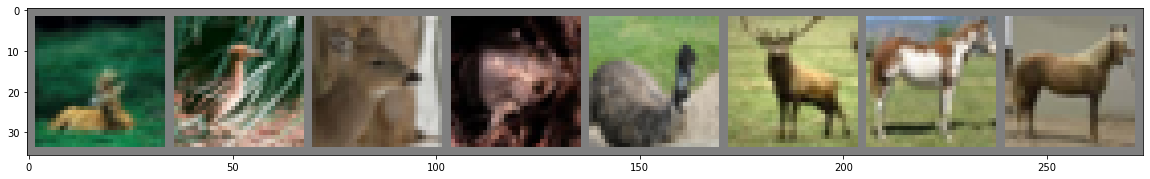

	 deer		   bird		   deer		   frog		   bird		   deer		  horse		  horse


In [0]:
# get some random training images
dataiter = iter(no_aug_train_loader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize=(20,5))
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print('\t'+'\t\t  '.join('%5s' % classes[labels[j]] for j in range(8)))

## Convolutional Neural Network (CNN)

### Model definition

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3)
        self.bn_conv1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3)
        self.bn_conv2 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)

        # output_size = (Width - Filter(kernel_size) + 2*Padding) / Stride + 1
        # output_size = (32 - 3 + 0) / 1 + 1 = 30
        # >>> (64, 30, 30)
        # output_size = (30 - 3 + 0) / 1 + 1 = 28
        # >>> (128, 30, 30)
        # after pooling:
        # >>> (128, 14, 14)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn_conv3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, 3)
        self.bn_conv4 = nn.BatchNorm2d(512)


        # output_size = (14 - 3 + 2*1) / 1 + 1 = 14
        # >>> (256, 14, 14)
        # output_size = (14 - 3 + 0) / 1 + 1 = 12
        # >>> (512, 12, 12)
        # after pooling:
        # >>> (512, 6, 6)

        self.conv5 = nn.Conv2d(512, 1024, 3)
        self.bn_conv5 = nn.BatchNorm2d(1024)

        self.conv6 = nn.Conv2d(1024, 2048, 3)
        self.bn_conv6 = nn.BatchNorm2d(2048)
        
        # output_size = (6 - 3 + 0) / 1 + 1 = 4
        # >>> (1024, 4, 4)
        # output_size = (4 - 3 + 0) / 1 + 1 = 2
        # >>> (2048, 2, 2)
        # after pooling:
        # >>> (2048, 1, 1)

        self.fc1 = nn.Linear(2048 * 1 * 1, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = self.pool(F.relu(self.bn_conv2(self.conv2(x))))
        x = F.relu(self.bn_conv3(self.conv3(x)))
        x = self.pool(F.relu(self.bn_conv4(self.conv4(x))))
        x = F.relu(self.bn_conv5(self.conv5(x)))
        x = self.pool(F.relu(self.bn_conv6(self.conv6(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc1(self.fc2(x)))
        x = self.fc3(x)
        return x

### Training helper functions

In [0]:
def evaluate_model(dataloader):
    net.eval()

    correct = 0
    total = 0
    loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct, total, loss / len(dataloader)

In [0]:
def train_net(training_loader, n_epochs, save_snapshot_every=10, patience=10):

    global net, accuracies, losses, running_losses
    best_valid_loss = float('inf')
    best_valid_epoch = 0
    patience_count = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        # train_total = 0
        # train_correct = 0
        for i, data in enumerate(training_loader, 0):

            # set model to training mode
            net.train()

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        # print statistic and perform checks at the end of each epoch
        # set model to evaluation mode
        net.eval()

        # print statistics
        train_correct, train_total, train_loss = evaluate_model(training_loader)
        valid_correct, valid_total, valid_loss = evaluate_model(validloader)
        test_correct, test_total, test_loss = evaluate_model(testloader)
        
        train_acc = 100.0 * train_correct / train_total
        valid_acc = 100.0 * valid_correct / valid_total
        test_acc = 100.0 * test_correct / test_total

        accuracies.append([train_acc, valid_acc, test_acc])
        losses.append([train_loss, valid_loss, test_loss])
        running_losses.append([running_loss / len(training_loader)])

        print('[%3d, %4d] running loss: %2.3f    train_acc: %2.3f  valid_acc: %2.3f    train_loss: %1.3f  valid_loss: %1.3f' %
              (epoch + 1, i + 1, running_loss / len(training_loader), train_acc, valid_acc, train_loss, valid_loss))

        # increment patience counter
        patience_count += 1

        # save model every [save_snapshot_every] number of epochs
        if epoch % save_snapshot_every == 0 and epoch != 0:

            # delete existing snapshot of this epoch
            for f in glob.glob('snapshot_epoch_{}_model'.format(epoch)+'*'):
                os.remove(f)
            
            # save model, delete previous best
            torch.save(net, 'snapshot_epoch_{}_model.pt'.format(epoch))
        
        # update snapshot of model that achieves best validation loss
        if valid_loss < best_valid_loss:

            # model found with better validation accuracy
            best_valid_loss = valid_loss
            best_valid_epoch = epoch + 1
            snapshot_prefix = os.path.join(save_path, 'best_snapshot')
            snapshot_path = snapshot_prefix + '_valloss_{}_epoch_{}_model.pt'.format(valid_loss, epoch + 1)

            # save model, delete previous 'best_snapshot' files
            torch.save(net, snapshot_path)
            for f in glob.glob(snapshot_prefix + '_valloss_*'):
                if f != snapshot_path:
                    os.remove(f)

            # reset patience counter
            patience_count = 0
        
        # reached early stopping point (no improvement of valid loss after [patience] number of epochs)
        if patience_count >= patience:
            
            # revert model to best valid loss snapshot, since that is the best loss achieved
            snapshot_prefix = os.path.join(save_path, 'best_snapshot')
            snapshot_path = snapshot_prefix + '_valloss_{}_epoch_{}_model.pt'.format(best_valid_loss, best_valid_epoch)
            net = torch.load(snapshot_path, map_location=torch.device(device))

            print('Stopped Early')
            print('Model reverted to snapshot after epoch {} that achieved lowest validation loss at {}'.format(best_valid_epoch, best_valid_loss))

            return

    print('Finished Training')

### Models training


#### With training data augmentation


In [0]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv6): BatchNorm2d(2048, eps=1e-05,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [0]:
n_epochs = 100

accuracies = []
losses = []
running_losses = []

# Log initial accuracies (no training)
train_correct, train_total, train_loss = evaluate_model(trainloader)
valid_correct, valid_total, valid_loss = evaluate_model(validloader)
test_correct, test_total, test_loss = evaluate_model(testloader)

train_acc = 100.0 * train_correct / train_total
valid_acc = 100.0 * valid_correct / valid_total
test_acc = 100.0 * test_correct / test_total

accuracies.append([train_acc, valid_acc, test_acc])
losses.append([train_loss, valid_loss, test_loss])
running_losses.append([train_loss])

In [0]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_net(trainloader, n_epochs)

[  1,  625] running loss: 1.472    train_acc: 52.742  valid_acc: 56.240    train_loss: 1.376  valid_loss: 1.273
[  2,  625] running loss: 1.098    train_acc: 61.250  valid_acc: 64.830    train_loss: 1.170  valid_loss: 1.021
[  3,  625] running loss: 0.923    train_acc: 71.493  valid_acc: 74.780    train_loss: 0.941  valid_loss: 0.821
[  4,  625] running loss: 0.821    train_acc: 73.703  valid_acc: 78.880    train_loss: 0.886  valid_loss: 0.740
[  5,  625] running loss: 0.742    train_acc: 75.692  valid_acc: 78.920    train_loss: 0.819  valid_loss: 0.709
[  6,  625] running loss: 0.677    train_acc: 78.480  valid_acc: 81.630    train_loss: 0.737  valid_loss: 0.631
[  7,  625] running loss: 0.626    train_acc: 77.532  valid_acc: 79.260    train_loss: 0.758  valid_loss: 0.682
[  8,  625] running loss: 0.590    train_acc: 79.855  valid_acc: 82.470    train_loss: 0.683  valid_loss: 0.583
[  9,  625] running loss: 0.545    train_acc: 81.010  valid_acc: 82.870    train_loss: 0.664  valid_loss

Save finished trained model

In [0]:
snapshot_prefix = os.path.join(save_path, 'trained_model.pt')

for f in glob.glob(snapshot_prefix):
    os.remove(f)

torch.save(net, snapshot_prefix)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Save accuracies logged while training as csv file (for easy access later)

In [0]:
acc_np = np.array(accuracies)
losses_np = np.array(losses)
run_losses_np = np.array(running_losses)

np.savetxt(save_path+'accuracies.csv', acc_np, delimiter=',')
np.savetxt(save_path+'losses.csv', losses_np, delimiter=',')
np.savetxt(save_path+'running_losses.csv', run_losses_np, delimiter=',')

#### Without training data augmentation

In [0]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv6): BatchNorm2d(2048, eps=1e-05,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [0]:
n_epochs = 100

accuracies = []
losses = []
running_losses = []

# Log initial accuracies (no training)
train_correct, train_total, train_loss = evaluate_model(no_aug_train_loader)
valid_correct, valid_total, valid_loss = evaluate_model(validloader)
test_correct, test_total, test_loss = evaluate_model(testloader)

train_acc = 100.0 * train_correct / train_total
valid_acc = 100.0 * valid_correct / valid_total
test_acc = 100.0 * test_correct / test_total

accuracies.append([train_acc, valid_acc, test_acc])
losses.append([train_loss, valid_loss, test_loss])
running_losses.append([train_loss])

In [0]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_net(no_aug_train_loader, n_epochs)

[  1,  625] running loss: 1.198    train_acc: 65.448  valid_acc: 63.450    train_loss: 1.027  valid_loss: 1.057
[  2,  625] running loss: 0.774    train_acc: 75.228  valid_acc: 72.410    train_loss: 0.789  valid_loss: 0.845
[  3,  625] running loss: 0.597    train_acc: 80.975  valid_acc: 76.380    train_loss: 0.671  valid_loss: 0.766
[  4,  625] running loss: 0.468    train_acc: 87.450  valid_acc: 80.350    train_loss: 0.464  valid_loss: 0.619
[  5,  625] running loss: 0.378    train_acc: 90.915  valid_acc: 80.800    train_loss: 0.363  valid_loss: 0.581
[  6,  625] running loss: 0.281    train_acc: 90.295  valid_acc: 79.290    train_loss: 0.323  valid_loss: 0.600
[  7,  625] running loss: 0.212    train_acc: 92.115  valid_acc: 78.780    train_loss: 0.269  valid_loss: 0.625
[  8,  625] running loss: 0.151    train_acc: 96.103  valid_acc: 81.910    train_loss: 0.148  valid_loss: 0.534
[  9,  625] running loss: 0.122    train_acc: 95.555  valid_acc: 81.140    train_loss: 0.150  valid_loss

Save finished trained model

In [0]:
snapshot_prefix = os.path.join(save_path, 'trained_model_no_aug.pt')

for f in glob.glob(snapshot_prefix):
    os.remove(f)

torch.save(net, snapshot_prefix)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Save accuracies logged while training as csv file (for easy access later)

In [0]:
acc_np = np.array(accuracies)
losses_np = np.array(losses)
run_losses_np = np.array(running_losses)

np.savetxt(save_path+'accuracies_no_aug.csv', acc_np, delimiter=',')
np.savetxt(save_path+'losses_no_aug.csv', losses_np, delimiter=',')
np.savetxt(save_path+'running_losses_no_aug.csv', run_losses_np, delimiter=',')

### Model evaluation

#### With training data augmentation

In [0]:
net = torch.load(save_path+'trained_model.pt', map_location=torch.device(device))
net.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv6): BatchNorm2d(2048, eps=1e-05,

GroundTruths


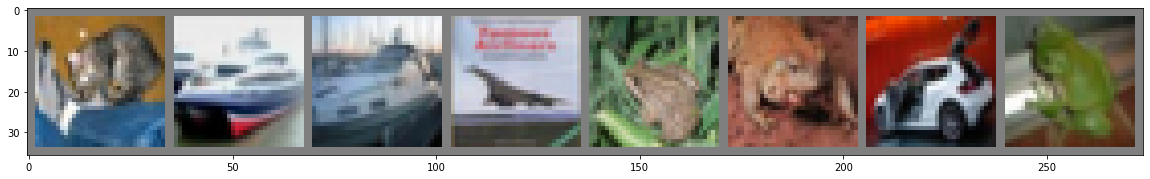

	  cat		   ship		   ship		  plane		   frog		   frog		    car		   frog


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
print('GroundTruths')
fig = plt.figure(figsize=(20,5))
imshow(torchvision.utils.make_grid(images[:8]))
print('\t'+'\t\t  '.join('%5s' % classes[labels[j]] for j in range(8)))

In [0]:
# feed model images to predict
outputs = net(images.to(device))

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predictions')
print('\t'+'\t\t  '.join('%5s' % classes[predicted[j]] for j in range(8)))

Predictions
	  cat		   ship		   ship		  plane		   frog		   frog		    car		   frog


In [0]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %2.3f %%\n' % (
    100.0 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 88.540 %

Accuracy of plane : 94 %
Accuracy of   car : 90 %
Accuracy of  bird : 84 %
Accuracy of   cat : 72 %
Accuracy of  deer : 85 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 87 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %


In [0]:
# Load accuracies from saved files
acc_np = np.genfromtxt(save_path+'accuracies.csv', delimiter=',')
losses_np = np.genfromtxt(save_path+'losses.csv', delimiter=',')
run_losses_np = np.genfromtxt(save_path+'running_losses.csv', delimiter=',')

Plot accuracies

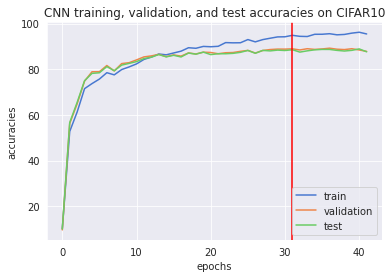

In [0]:
with sns.axes_style('darkgrid'):
    

    plt.title('CNN training, validation, and test accuracies on CIFAR10')
    plt.ylabel('accuracies')
    plt.xlabel('epochs')
    plt.plot(acc_np)
    plt.axvline(31, color='red')
    plt.legend(['train', 'validation', 'test'], loc='lower right')
    
    plt.show()
    # plt.savefig('accuracies.png')

Plot losses

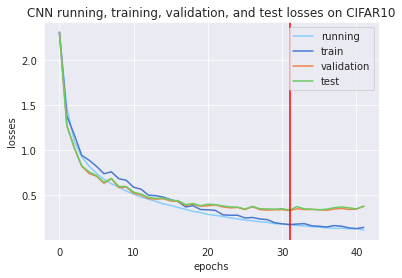

In [0]:
with sns.axes_style('darkgrid'):
    plt.title('CNN running, training, validation, and test losses on CIFAR10')
    plt.ylabel('losses')
    plt.xlabel('epochs')
    plt.plot(run_losses_np, color='lightskyblue')
    plt.plot(losses_np)
    plt.axvline(31, color='red')
    plt.legend(['running', 'train', 'validation', 'test'], loc='upper right')

    plt.show()
    # plt.savefig('losses.png')

#### Without training data augmentation

In [0]:
net = torch.load(save_path+'trained_model_no_aug.pt', map_location=torch.device(device))
net.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv6): BatchNorm2d(2048, eps=1e-05,

GroundTruths


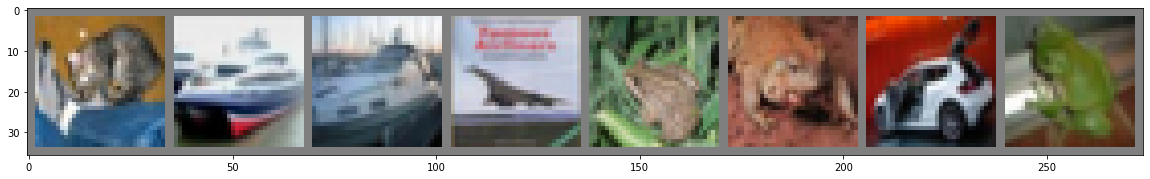

	  cat		   ship		   ship		  plane		   frog		   frog		    car		   frog


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
print('GroundTruths')
fig = plt.figure(figsize=(20,5))
imshow(torchvision.utils.make_grid(images[:8]))
print('\t'+'\t\t  '.join('%5s' % classes[labels[j]] for j in range(8)))

In [0]:
# feed model images to predict
outputs = net(images.to(device))

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predictions')
print('\t'+'\t\t  '.join('%5s' % classes[predicted[j]] for j in range(8)))

Predictions
	  cat		   ship		   ship		  plane		   frog		   frog		    car		   frog


In [0]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %2.3f %%\n' % (
    100.0 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 81.490 %

Accuracy of plane : 83 %
Accuracy of   car : 92 %
Accuracy of  bird : 87 %
Accuracy of   cat : 64 %
Accuracy of  deer : 74 %
Accuracy of   dog : 76 %
Accuracy of  frog : 87 %
Accuracy of horse : 81 %
Accuracy of  ship : 86 %
Accuracy of truck : 88 %


In [0]:
# Load accuracies from saved files
acc_np = np.genfromtxt(save_path+'accuracies_no_aug.csv', delimiter=',')
losses_np = np.genfromtxt(save_path+'losses_no_aug.csv', delimiter=',')
run_losses_np = np.genfromtxt(save_path+'running_losses_no_aug.csv', delimiter=',')

Plot accuracies

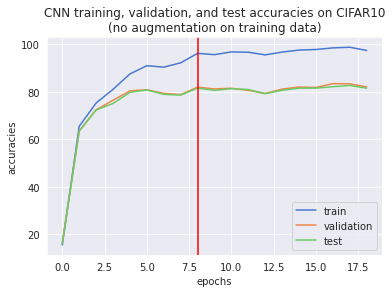

In [0]:
with sns.axes_style('darkgrid'):
    plt.title('CNN training, validation, and test accuracies on CIFAR10\n(no augmentation on training data)')
    plt.ylabel('accuracies')
    plt.xlabel('epochs')
    plt.plot(acc_np)
    plt.axvline(8, color='red')
    plt.legend(['train', 'validation', 'test'], loc='lower right')

    plt.show()
    # plt.savefig('accuracies.png')

Plot losses

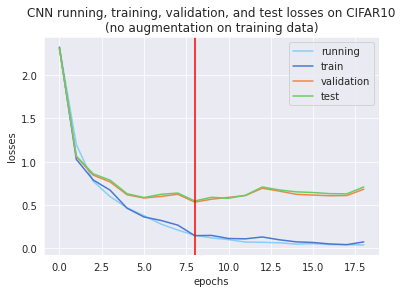

In [0]:
with sns.axes_style('darkgrid'):
    plt.title('CNN running, training, validation, and test losses on CIFAR10\n(no augmentation on training data)')
    plt.ylabel('losses')
    plt.xlabel('epochs')
    plt.plot(run_losses_np, color='lightskyblue')
    plt.plot(losses_np)
    plt.axvline(8, color='red')
    plt.legend(['running', 'train', 'validation', 'test'], loc='upper right')

    plt.show()
    # plt.savefig('losses.png')

## Preprocessing for MLP

In [0]:
# Train/validation sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Use SubsetRandomSampler to separate into train/validation
set_size = len(trainset)
indices = list(range(set_size))
split = int(np.floor(validation_size * set_size))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=40000,
                                          sampler=train_sampler, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=10000,
                                          sampler=valid_sampler, num_workers=4)

# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


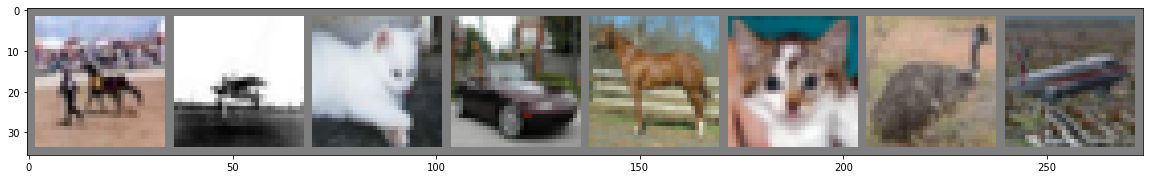

	horse		  plane		    cat		    car		  horse		    cat		   bird		  plane


In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize=(20,5))
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print('\t'+'\t\t  '.join('%5s' % classes[labels[j]] for j in range(8)))

Flatten images into 3072x1 vectors and convert to numpy arrays

One hot encode labels into numpy arrays

In [0]:
# Training set
dataiter = iter(trainloader)
images, labels = dataiter.next()
d1 = images.shape[0]

X_train = images.reshape((d1, -1)).numpy()
y_train_labels = labels
y_train = np.zeros((X_train.shape[0], 10))
y_train[range(len(y_train)), labels] += 1

# Validation set
dataiter = iter(validloader)
images, labels = dataiter.next()
d1 = images.shape[0]

X_valid = images.reshape((d1, -1)).numpy()
y_valid_labels = labels
y_valid = np.zeros((X_valid.shape[0], 10))
y_valid[range(len(y_valid)), labels] += 1

# Test set
dataiter = iter(testloader)
images, labels = dataiter.next()
d1 = images.shape[0]

X_test = images.reshape((d1, -1)).numpy()
y_test_labels = labels
y_test = np.zeros((X_test.shape[0], 10))
y_test[range(len(y_test)), labels] += 1

## Multilayer Perceptron (MLP)

### Model definition

In [0]:
def logsumexp(
    Z, #N x C
):
    Zmax = np.max(Z, axis=1)[:, None]
    lse = Zmax + np.log(np.sum(np.exp(Z-Zmax), axis=1))[:, None]
    return lse #N

def softmax(
    u, #N x C
):
    u_exp = np.exp(u - np.max(u, 1)[:, None])
    return u_exp/np.sum(u_exp, axis=-1)[:, None]

In [0]:
class Loss():
    def forward(self):
        '''Vectorized loss function'''
        pass
    
    def grad(self):
        '''Vectorized derivative of loss function.'''
        pass

class SoftmaxCrossEntropyLoss(Loss):
    def forward(self, observed, predicted):
        nll = - np.mean(np.sum(predicted * observed, 1) - logsumexp(predicted))
        return nll
    def grad(self, observed, predicted):
        return predicted - observed

In [0]:
class Activation():
    def forward(self, input):
        '''Vectorized activation function.'''
        pass

    def grad(self):
        '''Vectorized derivative of activation function.'''
        pass

class Identity(Activation):
    def forward(self, input):
        return input
    def grad(self, input):
        return np.ones(len(input))

class ReLU(Activation):
    def forward(self, input):
        return input * (input > 0)
    def grad(self, input):
        return (input > 0) * 1.0

class Sigmoid(Activation):
    def forward(self, input):
        return 1 / (1 + np.exp(-input)) 
    def grad(self, input):
        return input * (1 - input)

In [0]:
class Layer():
    def __init__(self, input_size, output_size, activation=None, weights=None, bias=None):
        if weights is not None:
            self.weights = weights
        else:
            self.weights = np.random.rand(input_size, output_size)
        
        if bias is not None:
            self.bias = bias
        else:
            self.bias = np.random.rand(output_size)
        
        if activation is not None:
            self.activation = activation
        else:
            self.activation = Identity()
    
    def compute(self, input):
        weighted_input = np.dot(input, self.weights)
        q = weighted_input + self.bias
        z = self.activation.forward(q)
        self.output = z
        return self.output

In [0]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
import numpy as np
import random
from copy import deepcopy

class NN():
    
    def __init__(self):
        self._layers = []

    def add_layer(self, layer):
        self._layers.append(layer)

    def forward(self, X):
        # Feed forward through all layers
        for layer in self._layers:
            X = layer.compute(X)
        return X

    def backward(self, X, y, learning_rate, loss):

        # Output from feed forward
        output = self.forward(X)

        N, D = X.shape

        # Store gradients
        gradients = []

        # Loop through layers in reverse order
        for i in reversed(range(len(self._layers))):
            # Set current layer
            layer = self._layers[i]

            input = np.atleast_2d(X if i == 0 else self._layers[i - 1].output)
            
            # If current layer is the output layer
            if layer == self._layers[-1]:
                dZ = loss.grad(y, output)
                gradients.append(np.dot(input.T, dZ) / N)
            else:
                next_layer = self._layers[i + 1]    # Next layer relative to current layer
            
                dA = np.dot(dZ, next_layer.weights.T)
                dZ = layer.activation.grad(layer.output) * dA
                gradients.append(np.dot(input.T, dZ) / N)

        # Update weights
        for i in reversed(range(len(self._layers))):
            self._layers[i].weights -= learning_rate * gradients[len(self._layers) - 1 - i]

    def train(self, X, y, learning_rate, max_epochs, loss, batch_size=10, print_every=20, patience=10):

        global accuracies, losses

        best_net_temp = NN()

        best_valid_loss = float('inf')
        best_valid_epoch = 0
        patience_count = 0

        for epoch in range(max_epochs):
            for i, mini_batch in enumerate(iterate_minibatches(X, y, batch_size)):
                data, labels = mini_batch
                self.backward(data, labels, learning_rate, loss)
                # if i % print_every == 0:
                    # loss_value = loss.forward(y, self.forward(X))
                    # losses.append(loss_value)
                    # print('[%2d,%4d] loss: %f' % (epoch + 1, i + 1, float(loss_value)))

            # Calculate train, valid, test accuracies at end of each epoch
            train_acc = np.mean(mlp.predict(X_train) == y_train_labels.numpy())
            valid_acc = np.mean(mlp.predict(X_valid) == y_valid_labels.numpy())
            test_acc = np.mean(mlp.predict(X_test) == y_test_labels.numpy())

            train_loss = float(loss.forward(y_train, self.forward(X_train)))
            valid_loss = float(loss.forward(y_valid, self.forward(X_valid)))
            test_loss = float(loss.forward(y_test, self.forward(X_test)))


            accuracies.append([train_acc, valid_acc, test_acc])
            losses.append([train_loss, valid_loss, test_loss])

            print('[%3d, %4d]    train_acc: %2.3f  valid_acc: %2.3f  test_acc: %2.3f    train_loss: %1.3f  valid_loss: %1.3f  test_loss: %1.3f' %
                  (epoch + 1, i + 1, train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss))

            # increment patience counter
            patience_count += 1

            # update snapshot of model that achieves best validation loss
            if valid_loss < best_valid_loss:

                # model found with better validation accuracy
                best_net_temp = deepcopy(self)

                # reset patience counter
                patience_count = 0
            
            # reached early stopping point (no improvement of valid loss after [patience] number of epochs)
            if patience_count >= patience:

                print('Stopped Early')
                print('Model reverted to snapshot after epoch {} that achieved lowest validation loss at {}'.format(best_valid_epoch, best_valid_loss))

                return best_net_temp
        return best_net_temp

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

### Model training

In [0]:
def XavierInitialization(input_size, output_size):
    return np.random.uniform(-math.sqrt(6. / (input_size + output_size)), math.sqrt(6. / (input_size + output_size)), (input_size, output_size))

In [0]:
mlp = NN()

# Model used for testing transforms
# mlp.add_layer(Layer(3072, 1024, ReLU(), weights=np.random.uniform(-math.sqrt(6. / (3072 + 1024)), math.sqrt(6. / (3072 + 1024)), (3072, 1024))))
# mlp.add_layer(Layer(1024, 128, ReLU(), weights=np.random.uniform(-math.sqrt(6. / (1024 + 128)), math.sqrt(6. / (1024 + 128)), (1024, 128))))
# mlp.add_layer(Layer(128, 10, ReLU(), weights=np.random.uniform(-math.sqrt(6. / (128 + 10)), math.sqrt(6. / (128 + 10)), (128, 10))))

# Final model (best model)
mlp.add_layer(Layer(3072, 1024, ReLU(), weights=XavierInitialization(3072, 1024)))
mlp.add_layer(Layer(1024, 512, ReLU(), weights=XavierInitialization(1024, 512)))
mlp.add_layer(Layer(512, 512, ReLU(), weights=XavierInitialization(512, 512)))
mlp.add_layer(Layer(512, 10, ReLU(), weights=XavierInitialization(512, 10)))

In [0]:
print(X_train.shape)
print(y_train.shape)

(40000, 3072)
(40000, 10)


In [0]:
accuracies = []
losses = []

loss = SoftmaxCrossEntropyLoss()

# Calculate train, valid, test accuracies at end of each epoch
train_acc = np.mean(mlp.predict(X_train) == y_train_labels.numpy())
valid_acc = np.mean(mlp.predict(X_valid) == y_valid_labels.numpy())
test_acc = np.mean(mlp.predict(X_test) == y_test_labels.numpy())

train_loss = float(loss.forward(y_train, mlp.forward(X_train)))
valid_loss = float(loss.forward(y_valid, mlp.forward(X_valid)))
test_loss = float(loss.forward(y_test, mlp.forward(X_test)))


accuracies.append([train_acc, valid_acc, test_acc])
losses.append([train_loss, valid_loss, test_loss])

In [0]:
print(accuracies)
print(losses)

[[0.064075, 0.0654, 0.0641]]
[[2.7038330821282917, 2.70300220080128, 2.708346420554043]]


In [0]:
best_mlp = mlp.train(X_train, y_train, 0.01, 30, SoftmaxCrossEntropyLoss(), batch_size=128)

[  1,  312]    train_acc: 0.396  valid_acc: 0.371  test_acc: 0.386    train_loss: 2.132  valid_loss: 2.144  test_loss: 2.140
[  2,  312]    train_acc: 0.413  valid_acc: 0.387  test_acc: 0.389    train_loss: 2.115  valid_loss: 2.132  test_loss: 2.130
[  3,  312]    train_acc: 0.463  valid_acc: 0.421  test_acc: 0.426    train_loss: 2.096  valid_loss: 2.119  test_loss: 2.115
[  4,  312]    train_acc: 0.487  valid_acc: 0.436  test_acc: 0.437    train_loss: 2.085  valid_loss: 2.113  test_loss: 2.109
[  5,  312]    train_acc: 0.508  valid_acc: 0.447  test_acc: 0.453    train_loss: 2.066  valid_loss: 2.098  test_loss: 2.094
[  6,  312]    train_acc: 0.525  valid_acc: 0.453  test_acc: 0.457    train_loss: 2.066  valid_loss: 2.102  test_loss: 2.099
[  7,  312]    train_acc: 0.540  valid_acc: 0.468  test_acc: 0.466    train_loss: 2.054  valid_loss: 2.093  test_loss: 2.089
[  8,  312]    train_acc: 0.547  valid_acc: 0.465  test_acc: 0.468    train_loss: 2.042  valid_loss: 2.085  test_loss: 2.081


### Model evaluation

Test accuracy

In [0]:
np.mean(best_mlp.predict(X_test) == y_test_labels.numpy())

0.5086

Plot accuracies

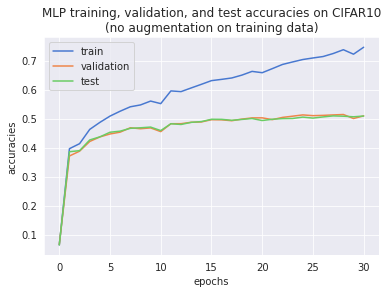

In [0]:
with sns.axes_style('darkgrid'):
    sns.set_palette('muted')
    plt.title('MLP training, validation, and test accuracies on CIFAR10\n(no augmentation on training data)')
    plt.ylabel('accuracies')
    plt.xlabel('epochs')
    plt.plot(accuracies)
    plt.legend(['train', 'validation', 'test'])

    plt.show()
    # plt.savefig('accuracies.png')

Plot losses

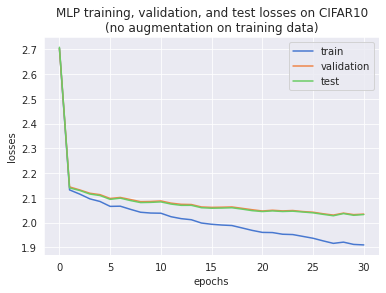

In [0]:
with sns.axes_style('darkgrid'):
    plt.title('MLP training, validation, and test losses on CIFAR10\n(no augmentation on training data)')
    plt.ylabel('losses')
    plt.xlabel('epochs')
    plt.plot(losses)
    plt.legend(['train', 'validation', 'test'])

    plt.show()
    # plt.savefig('losses.png')